In [255]:
# Importing necessary libraries

import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

# Model fit evaluation libraries

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# Model building libraries

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

# Plotting libraries

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [256]:
# Data import and creation of database

df=pd.read_csv('BTC-USD.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/1/20,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,1.856566e+10
1,1/2/20,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,2.080208e+10
2,1/3/20,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,2.811148e+10
3,1/4/20,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,1.844427e+10
4,1/5/20,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,1.972507e+10


In [257]:
# Exploration of closing price data

closedf = df[['Date','Close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (781, 2)


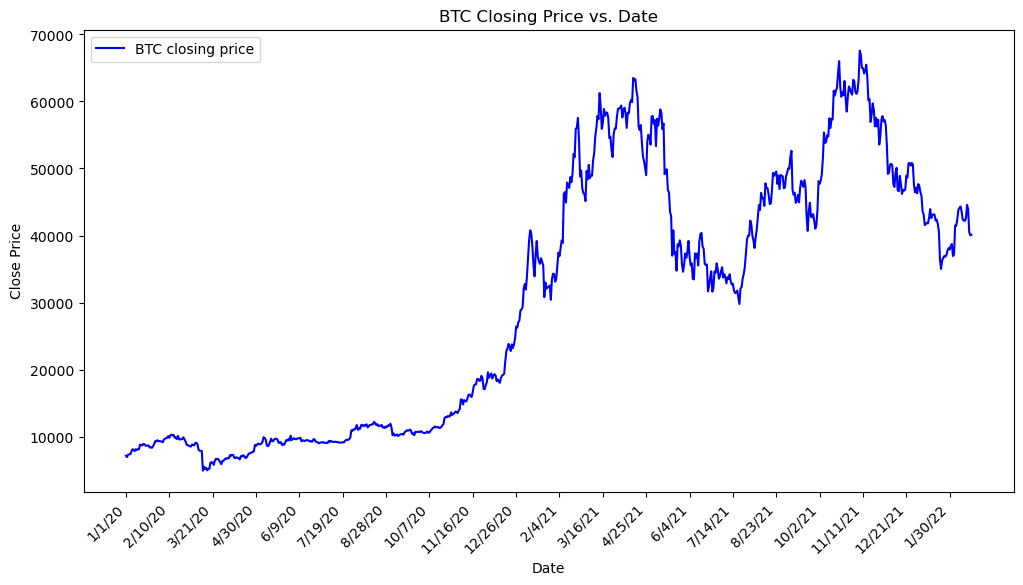

In [258]:
# Plot of original closing price data of BTC

plt.figure(figsize=(12, 6))
plt.plot(closedf['Date'], closedf['Close'], color='blue', label='BTC closing price')
plt.xticks(df['Date'][::40], rotation=45, ha='right')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('BTC Closing Price vs. Date')
plt.legend()
plt.show()

In [259]:
# Deleting date column and normalizing using MinMax scaler

del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(781, 1)


In [260]:
# Designate 70% of the data as the training set and 30% as the testing set

training_size=int(len(closedf)*0.7)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (546, 1)
test_data:  (235, 1)


In [261]:
# Convert an array of values into a dataset matrix

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [262]:
# Prepare training and testing arrays

time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (535, 10)
y_train:  (535,)
X_test:  (224, 10)
y_test (224,)


In [263]:
# Reshape input to be [samples, time steps, features] which is required for LSTM

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (535, 10, 1)
X_test:  (224, 10, 1)


In [264]:
# Prepare the LSTM model, i.e. specify number of LSTM units and activation method

model=Sequential()
model.add(LSTM(12,input_shape=(None,1),activation="relu"))
model.add(Dense(1))
model.compile(loss="mean_squared_error",optimizer="adam")

In [265]:
# Run the actual LSTM model

history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=25,batch_size=16,verbose=1)

Epoch 1/25
34/34 [==============================] - 0s 4ms/step - loss: 0.1294 - val_loss: 0.3128
Epoch 2/25
34/34 [==============================] - 0s 2ms/step - loss: 0.0719 - val_loss: 0.1220
Epoch 3/25
34/34 [==============================] - 0s 2ms/step - loss: 0.0200 - val_loss: 0.0028
Epoch 4/25
34/34 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0041
Epoch 5/25
34/34 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 6/25
34/34 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 7/25
34/34 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 8/25
34/34 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 9/25
34/34 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 10/25
34/34 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 11/25
34/34 [

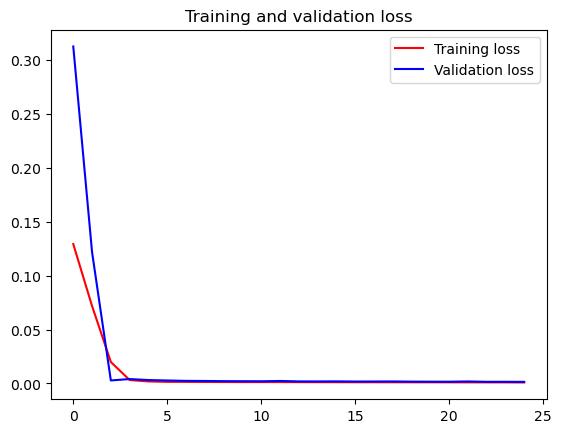

<Figure size 640x480 with 0 Axes>

In [266]:
# Create plot of training and validation loss

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [267]:
# Perform the prediction and check performance metrics

train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

7/7 [==============================] - 0s 605us/step


((535, 1), (224, 1))

In [268]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [270]:
# Evaluation metrics for performance of algorithm

print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))
print("-------------------------------------------------------------------------------------")
print("Train data explained variance regression score:", 
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", 
      explained_variance_score(original_ytest, test_predict))
print("-------------------------------------------------------------------------------------")
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))
print("-------------------------------------------------------------------------------------")
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("-------------------------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data RMSE:  1891.2397373468339
Train data MSE:  3576787.7441197215
Train data MAE:  1119.0374387762852
-------------------------------------------------------------------------------------
Test data RMSE:  2441.186345534325
Test data MSE:  5959390.773623233
Test data MAE:  1945.4419555440843
-------------------------------------------------------------------------------------
Train data explained variance regression score: 0.9887083927075098
Test data explained variance regression score: 0.92335872014853
-------------------------------------------------------------------------------------
Train data R2 score: 0.9886665171140048
Test data R2 score: 0.9215028461142741
-------------------------------------------------------------------------------------
Train data MGD:  0.004283734287813897
Test data MGD:  0.002621222741099464
-------------------------------------------------------------------------------------
Train data MPD:  97.01243676260862
Test data MPD:  123.01121521524131


In [271]:
# Check training and testing shapes before plotting

train_predict.shape
test_predict.shape

(224, 1)

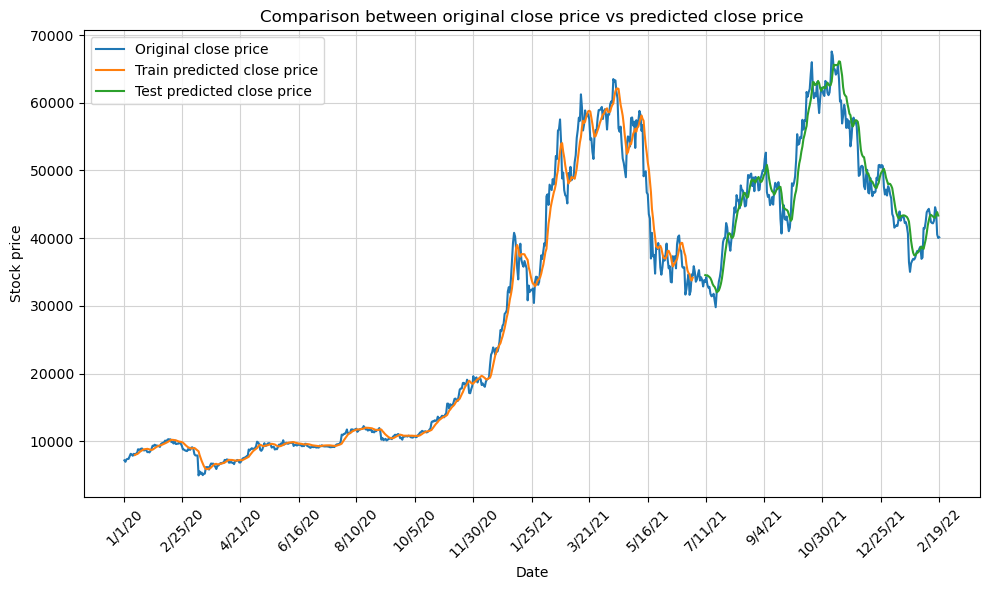

In [296]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

# Shift train predictions for plotting
close_stock = df[['Date', 'Close']]
look_back = time_step
trainPredictPlot = np.empty_like(close_stock['Close'])
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back] = train_predict.flatten()

# Shift test predictions for plotting
testPredictPlot = np.empty_like(close_stock['Close'])
testPredictPlot[:] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2) + 1:len(close_stock['Close']) - 1] = test_predict.flatten()

names = cycle(['Original close price', 'Train predicted close price', 'Test predicted close price'])

# Plotting routine
plt.figure(figsize=(10, 6))
plt.plot(close_stock['Date'], close_stock['Close'], label='Original close price')
plt.plot(close_stock['Date'], trainPredictPlot, label='Train predicted close price')
plt.plot(close_stock['Date'], testPredictPlot, label='Test predicted close price')
plt.grid(color='lightgrey')
plt.title('Comparison between original close price vs predicted close price')
plt.xlabel('Date')
plt.ylabel('Stock price')
tick_indices = np.linspace(0, len(close_stock['Date']) - 1, 15, dtype=int)
plt.xticks(tick_indices, close_stock['Date'].iloc[tick_indices], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()